# Pytorch Basic  

작성자: 김국진 kukjinkim@korea.ac.kr  


금일 실습 시간에는 Pytorch를 통해 간단한 회귀문제에 대해 실습할 것입니다.

# Contents
- Class Review 
- Tensor, Tensor Manipulation
- What is deep learning? <-
- Regresseion <-
- Dataset, DataLoader <-
- Optimizer <-
- Classification


# 1. What is deep learning?  

바야흐로 딥러닝의 시대입니다. ChatGPT부터 AI스피커, 로보틱스, 컴퓨터 비전 등 다양한 분야에 딥러닝이 응용되고 있습니다.  
딥러닝의 실체는 과연 무엇일까요? 딥러닝의 개념 자체는 매우 간단합니다. 한 마디로 요약하자면  

### 비선형함수를 최적화해서 원하는 문제를 푸는 과정

이라고 볼 수 있습니다. 아래 그림의 $f(x)$를 잘 학습해서 원하는 출력값을 내도록 만드는 것입니다. (분류, 회귀 문제)

![](2023-05-02-22-03-24.png)


그리고 $f(x)$의 경우 실제로는 위 그림처럼 여러 개의 층으로 이루어져 있습니다. $f(x)$의 실체는 입력값을 행렬곱을 수행하고 비선형함수를 통과시키는 과정을 반복하는 것입니다.  
위 그림은 이 과정을 도식화한 것입니다. 이것의 실체를 살펴보기 위해 간단한 회귀문제 정의하고 풀어보겠습니다.  

# 2. Regression  


### Simple Linear regression
회귀문제는 실수형 독립변수의 값들을 통해 실수형 종속변수의 값을 예측하는 작업입니다.  
먼저 선형적으로 증가하는 데이터셋을 만들어보겠습니다.  $y=2x$ 의 간단한 데이터들이며, 관측과정에서 노이즈가 포함되어있습니다. 

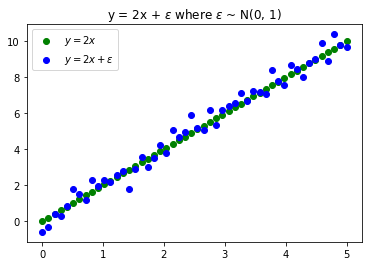

In [165]:
import matplotlib.pyplot as plt
import numpy as np

x_dataset = np.linspace(0, 5, 50, dtype=np.float32)
y_dataset = 2 * x_dataset
epsilon = np.random.normal(size=50, loc=0, scale=0.5)
noisy_y = y_dataset + epsilon
# plt.scatter(x,noisy_y)

plt.scatter(x_dataset, y_dataset, color='g')
plt.scatter(x_dataset, noisy_y, color='b')
plt.legend(['$y=2x$', '$y=2x + \epsilon$'], loc = 'best')
plt.title('y = 2x + $\epsilon$ where $\epsilon$ ~ N(0, 1)')
plt.show()

위와 같이 선형적으로 값이 증가하는 데이터가 있다면 특정 $x$값을 입력받았을 때, 해당하는 $y$값을 잘 예측하는 것입니다. 이와 같은 문제를 회귀문제라고 합니다. 


우리는 이 문제를 아래 식과 같이 간단헌 선형회귀모델을 통해 간단하게 풀 수 있습니다. 여기서 선형이라는 말은 모델이 계수와 독립변수들의 선형결합으로 표현되어 있다는 의미입니다. 

$$ y = wx + b $$

아래의 코드들로 $y=wx+b$ 를 그려보겠습니다.  

In [166]:
import torch
import torch.nn as nn
# y = wx + b
torch.manual_seed(64)
linear_model = nn.Linear(1, 1).to(dtype=torch.float) # 첫번째 인자 : 입력의 차원, 두번째 인자 : 출력의 차원
print(linear_model.weight)
print(linear_model.weight.shape)
print(linear_model.bias)
pred_y_list = []
for x in x_dataset:
    pred_y = linear_model(torch.tensor(x).unsqueeze(0)) # 행렬 곱을 위해 0차원을 1차원으로 만듬
    pred_y_list.append(pred_y.item())
    

Parameter containing:
tensor([[-0.9016]], requires_grad=True)
torch.Size([1, 1])
Parameter containing:
tensor([0.1979], requires_grad=True)


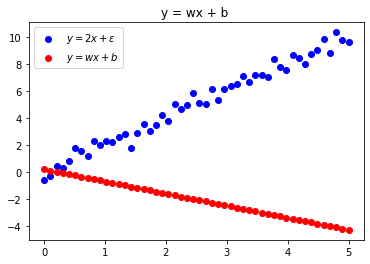

In [167]:
plt.scatter(x_dataset, noisy_y, color='b')
plt.scatter(x_dataset, pred_y_list, color='r')
plt.legend(['$y=2x + \epsilon$', '$y=wx+b$'], loc = 'best')
plt.title('y = wx + b ')
plt.show()

우리의 목표는 빨간선이 파란색 데이터들을 잘 표현하도록 $w, b$를 잘 조정하는 것입니다.  
$w, b$를 모델의 가중치 또는 파라미터라고 부르며 이것을 조정하는 것을 우리는 **모델을 학습한다** 또는 모델을 최적화한다고 말합니다. 

## Gradient descent  
그렇다면 파라미터를 어떻게 학습할 수 있을까요? 선형회귀 모델의 경우 정규방정식이나 경사하강법이라는 것을 통해 풀 수 있습니다.  

![](2023-05-02-16-06-50.png)  

$$ w = w - \alpha {dL \over dw} $$ 
경사하강법은 가중치에 대한 손실함수 (Cost) 값의 변화량 ${dL \over dw}$를 통해 가중치를 업데이트 하는 방식입니다. 위의 식이 경사하강법을 표현한식이며, 알파값은 학습률(learning rate)이라고 부르고, 경사를 얼마나 하강시키는지에 대한 보폭 (step size)를 나타냅니다.   


여기서 손실함수는 우리가 최적화하고자하는 대상으로 문제에 따라 다르게 정의됩니다. 최적화는 함수값을 최소화하거나 최대화하는 것을 의미합니다.  
회귀 문제에서는 아래와 같이 Mean squared error (MSE)를 목적함수로 사용합니다. 그 의미는 모델의 출력값과 정답값의 차이의 제곱 정의한 것입니다.  
우리는 MSE 값을 최소화하면 error가 0이 되고, w와 b의 학습이 완료됩니다. 
$$MSE := {1\over N }\sum_{i=1}^N (y - \hat y)^2 $$  
$\hat y$는 모델의 예측값을 표기한 기호입니다. 이제 경사하강법을 수행해보겠습니다.  

Pytorch에서는 여러 손실함수들 `cross_entropy, mse_loss` 등등이 미리 정의되어있어서 편리하게 사용할 수 있습니다. 아래 코드에서는 Stochastic Gradient Descent를 수행해서 square_error를 loss로 사용했습니다. 
gradient의 경우 autograd를 통해 자동으로 계산할 수 있습니다.  
아래 코드와 같이 `loss.backward()`를 수행하면 모든 가중치에 대한 그래디언트 값이 계산됩니다.  
이를 토대로 $ w = w - \alpha {dL \over dw} $ 를 수행해서 업데이트를 진행합니다.  

In [175]:
num_epochs = 5
torch.manual_seed(64)
linear_model = nn.Linear(1, 1).to(dtype=torch.float)

lr = 0.01
loss_list = []
w_list = []
b_list = []
w_grad_list = []
b_grad_list = []
x_tensor = torch.tensor(x_dataset).unsqueeze(1)
y_tensor = torch.tensor(y_dataset)
print(x_tensor.shape)
data_length = x_tensor.shape[0]

total_steps = 0
for e in range(num_epochs):
    total_loss = 0
    torch.manual_seed(e)
    # Data shuffling for stochastic gradient descent
    random_indices = torch.randperm(data_length)
    shuffled_x = x_tensor[random_indices]
    shuffled_y = y_tensor[random_indices]
    for x, y in zip(shuffled_x, shuffled_y):
        # Prediction
        y_pred = linear_model(x) 
        loss = (y_pred - y) ** 2 # Squared error
        total_loss += loss.item()
        
        # Calculate gradients
        loss.backward()
        if total_steps % 10 == 0:
            print(f"step: {total_steps}, loss: {loss.item()}")

        # Update
        linear_model.weight.data = linear_model.weight.data - lr * linear_model.weight.grad.item()
        linear_model.bias.data = linear_model.bias.data - lr * linear_model.bias.grad.item()
        w_grad_list.append(linear_model.weight.grad.item())
        b_grad_list.append(linear_model.bias.grad.item())
        
        # Reset gradient
        linear_model.weight.grad.data.zero_()
        linear_model.bias.grad.data.zero_()
        
        # Record loss, grad
        loss_list.append(loss.item())
        w_list.append(linear_model.weight.data)
        b_list.append(linear_model.bias.data)

        total_steps += 1
    
    # Record items
    if e % 50 == 0:
        print(loss.item())
    


torch.Size([50, 1])
step: 0, loss: 164.5967559814453
step: 10, loss: 1.331082820892334
step: 20, loss: 0.12742406129837036
step: 30, loss: 0.39471694827079773
step: 40, loss: 0.11571556329727173
0.1149691641330719
step: 50, loss: 0.20159275829792023
step: 60, loss: 0.09303740411996841
step: 70, loss: 0.16804924607276917
step: 80, loss: 0.019570866599678993
step: 90, loss: 0.37300175428390503
step: 100, loss: 0.05960511043667793
step: 110, loss: 0.05384385585784912
step: 120, loss: 0.12148591130971909
step: 130, loss: 0.044862717390060425
step: 140, loss: 0.24279987812042236
step: 150, loss: 0.0002806855773087591
step: 160, loss: 0.03403487429022789
step: 170, loss: 0.001403419068083167
step: 180, loss: 0.03569365665316582
step: 190, loss: 0.02771211974322796
step: 200, loss: 0.0019175938796252012
step: 210, loss: 0.0008727279491722584
step: 220, loss: 0.0772574245929718
step: 230, loss: 0.01583671197295189
step: 240, loss: 0.06129050999879837


c:\Users\ye200\anaconda3\envs\minerl\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\ye200\anaconda3\envs\minerl\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
c:\Users\ye200\anaconda3\envs\minerl\lib\site-packages\numpy\cor

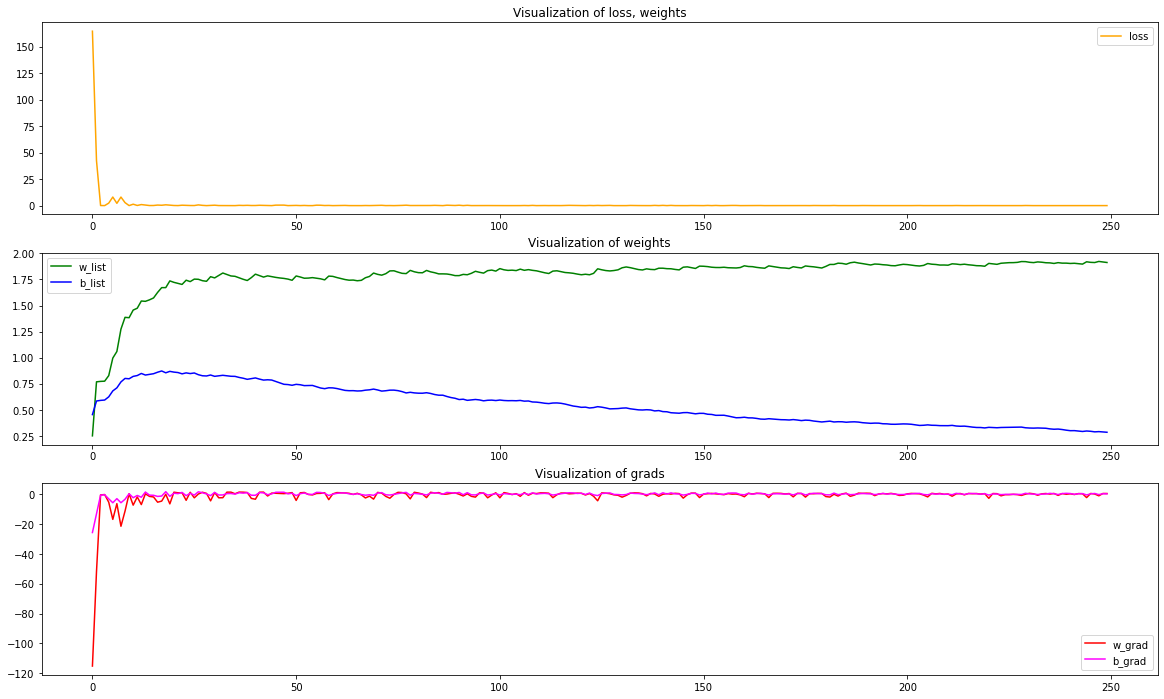

In [176]:
steps = np.arange(total_steps)
plt.figure(figsize=(20,12))
plt.subplot(3, 1, 1)  
plt.plot(steps, loss_list, color='orange')
plt.title('Visualization of loss')
plt.legend(['loss'], loc = 'best')

plt.subplot(3, 1, 2)  
plt.plot(steps, w_list, color='green')
plt.plot(steps, b_list, color='blue')
plt.title('Visualization of weights')
plt.legend(['w_list', 'b_list'], loc = 'best')


plt.subplot(3, 1, 3)  
plt.plot(steps, w_grad_list, color='red')
plt.plot(steps, b_grad_list, color='magenta')
plt.legend(['w_grad', 'b_grad'], loc = 'best')
plt.title('Visualization of grads')
plt.show()

위 그래프는 업데이트 횟수에 따른 손실함수, 가중치, 그래디언트의 변화를 기록한 것입니다.  
그래디언트의 경우 0에 수렴하고 있고, $w, b$ 또한 실제 값인 2와 0에 수렴하는 것을 볼 수 있습니다.  
학습이 잘 진행되어서 모두 수렴하는 것을 확인할 수 있습니다. 이제 학습된 모델로 예측을 수행하면 데이터에 대해서 정확한 예측 결과를 내놓을 것입니다.  

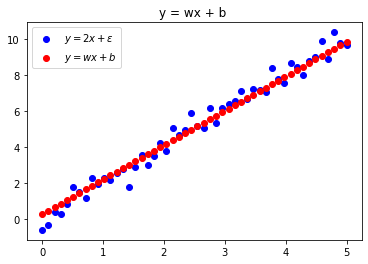

In [180]:
pred_y_list = []
for x in x_dataset:
    pred_y = linear_model(torch.tensor(x).unsqueeze(0)) 
    pred_y_list.append(pred_y.item())
plt.scatter(x_dataset, noisy_y, color='b')
plt.scatter(x_dataset, pred_y_list, color='r')
plt.legend(['$y=2x + \epsilon$', '$y=wx+b$'], loc = 'best')
plt.title('y = wx + b ')
plt.show()

## Non-linear regression

지금까지 간단한 선형회귀 문제를 살펴보았습니다. 하지만 세상의 많은 데이터들은 **비선형**인 특징을 가져서 단순한 선형 모델로는 표현하기 어렵습니다.  아래와 같이 복잡한 형태의 함수와 같은 경우는 위와 같은 선형회귀 모델로 학습할 수 없습니다.  

$$y = -\exp (x)/10 + x^2\sin(x) +2x + 5$$

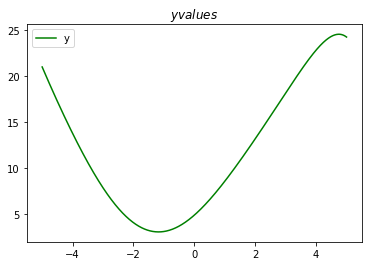

In [262]:
x_dataset = np.linspace(-5, 5, 1000, dtype=np.float32)
y_dataset = -np.exp(x_dataset)/10 + np.power(x_dataset, 2) + np.sin(x_dataset) + 2 * x_dataset + 5

plt.plot(x_dataset, y_dataset, color='g')
plt.legend(['y'], loc = 'best')
plt.title('$y values$')
plt.show()

### Neural Networks

![](2023-05-02-15-26-43.png)  
  
![](2023-05-02-15-29-27.png)

이러한 복잡한 함수들을 딥러닝을 통해서 근사시킬 수 있습니다. 딥러닝을 하기 위해서는 Neural networks를 먼저 정의해야 합니다. 가장 기본적인 뉴럴 네트워크는 **Multi Layer Perceptron (MLP)**입니다. 이 네트워크는 여러 개의 행렬들과 활성화함수들로 구성되어 있습니다.  
Pytorch의 nn.Module을 사용해서 아래와 같은 식을 가지는 NN을 정의해보겠습니다.  

$$\begin{align} y &= f(x) \\ &= W_3 (\sigma (W_2 (\sigma (W_1 x)))) \end{align}$$

`__init__()`의 경우 보통 뉴럴 네트워크의 레이어를 정의하는데 사용합니다.  
`forward()`에서는 뉴럴 네트워크의 연산방식을 정의합니다. 

#### Activation Function
위 식에서 $\sigma$의 경우 비선형함수로 뉴럴 네트워크가 비선형변환을 수행하도록 해줍니다. 대표적인 예시로는 ReLU, GeLU, LeakyReLU, Sigmoid, Tanh 등이 있습니다. 사용법은 아래와 같습니다. 

```Python
import torch.nn.functional as F
non_linear_feature = F.relu(feature)
```

```Python
import torch.nn as nn
relu = nn.ReLU()
non_linear_feature = relu(feature)
```

In [272]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(1, 128) # weight matrix W_1 = [128, 1]
        self.hidden_layer = nn.Linear(128, 128) # weight matrix W_2 = [128, 128]
        self.output_layer = nn.Linear(128, 1) # weight matrix W_3 = [1, 128]
    
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        y_pred = self.hidden_layer(x)
        return y_pred
        

## Dataset, DataLoader

선형회귀 모델을 학습시킬 때 우리는 mini_batch_size=1로 SGD를 수행하였습니다. 하지만 이 방식은 뉴럴 네트워크를 호출하는 횟수가 증가해서 학습이 매우 느려지게 됩니다. 우리는 데이터를 한꺼번에 입력해서 한거번에 출력을 얻을 필요가 있습니다.  
  
이를 batch training이라고 부릅니다.  전체 데이터를 한 번에 학습하는 방식은 full-batch 라고 부르며, 부분으로 나누는 것을 mini-batch 라고 부릅니다. mini batch size는 분할된 데이터의 크기를 의미합니다.
  
  
![](2023-05-02-17-59-05.png)  
출처: https://seamless.tistory.com/38

이렇게 mini-batch 방식으로 데이터를 학습하기 위해 DataLoader와 Dataset 모듈을 활용할 수 있습니다.  
DataLoader 모듈은 데이터셋과 mini batch size를 입력받아서 인스턴스를 생성합니다. 학습할 때 미니배치를 구성해줍니다. 



In [273]:
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset

In [274]:
class CustomDataset(Dataset):
    def __init__(self, x_dataset, y_datset):
        # 커스텀 데이셋 클래스의 생성자를 정의
        # 데이터를 불러와서 torch.tensor로 할당 및 전처리한다.
        self.x_data = torch.from_numpy(x_dataset).unsqueeze(1)
        self.y_data = torch.from_numpy(y_dataset).unsqueeze(1)
        print(f'X shape :{self.x_data.shape} | Y shape :{self.y_data.shape} ')
    
    # 매직 메소드 : 함수 이름 앞, 뒤로 underbar 2개를 붙인 메소드
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # 데이터셋에서 해당 인덱스에 해당하는 샘플 (x, y)를 가져오는 메소드
        return self.x_data[idx], self.y_data[idx]
    
dataset = CustomDataset(x_dataset, y_dataset)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True) 



X shape :torch.Size([1000, 1]) | Y shape :torch.Size([1000, 1]) 


In [275]:
import torch.optim as optim

## Optimizer  
옵티마이저는 뉴럴 네트워크의 파라미터를 입력 받아서 Gradient descent를 편리하게 진행해주는 모듈입니다.  
아래와 같은 방식으로 정의합니다. 
```Python
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.paramters(), lr=learning_rate)
```

사용할 때는 먼저 그래디언트를 0으로 초기화하고 그래디언트를 계산한 다음, step을 통해 업데이트를 수행합니다. 
```Python
optimizer.zero_gard()
loss.backward() 
optimizer.step()
```


## Chage update code parts simply

선형회귀 모델의 업데이트 부분은 아래와 같았습니다. 이제 DataLoader와 Optimizer를 통해 아래 코드를 일반화한 train function을 정의해보겠습니다. train function과 아래 코드를 비교해보세요 :)
```Python
for e in range(num_epochs):
    total_loss = 0
    torch.manual_seed(e)
    # Data shuffling for stochastic gradient descent
    random_indices = torch.randperm(data_length)
    shuffled_x = x_tensor[random_indices]
    shuffled_y = y_tensor[random_indices]
    for x, y in zip(shuffled_x, shuffled_y):
        # Prediction
        y_pred = linear_model(x) 
        loss = (y_pred - y) ** 2 # Squared error
        total_loss += loss.item()
        
        # Calculate gradients
        loss.backward()
        
        # Update
        linear_model.weight.data = linear_model.weight.data - lr * linear_model.weight.grad.item()
        linear_model.bias.data = linear_model.bias.data - lr * linear_model.bias.grad.item()
        
        # Reset gradient
        linear_model.weight.grad.data.zero_()
        linear_model.bias.grad.data.zero_()

        total_steps += 1
    
```

In [320]:
def train(device, model, optimizer, loss_func, data_loader, epochs, print_interval):
    epoch_loss_list = []
    for e in range(1, epochs+1):
        epoch_mean_loss = 0
        for mini_batch_index, samples in enumerate(data_loader):
            x_train, y_train = samples
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            output = model(x_train)
            optimizer.zero_grad()
            loss = loss_func(output, y_train) 
            loss.backward() 
            optimizer.step()
            if e % print_interval == 0:
                print(f'Epoch: {e:4d}/{epochs} MiniBatch: {mini_batch_index+1:4d}/{len(data_loader)} \
                    Loss: {loss.item():4f}')
            epoch_mean_loss += loss.item()
        epoch_loss_list.append(epoch_mean_loss/len(data_loader))
    return epoch_loss_list

In [353]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(42)
model = NeuralNetwork().to(device, dtype=torch.float)
loss_func = F.mse_loss
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr)
dataset = CustomDataset(x_dataset, y_dataset)
print_interval = 5
data_loader = DataLoader(dataset, batch_size=128, shuffle=True) 
epochs = 20


cuda
X shape :torch.Size([1000, 1]) | Y shape :torch.Size([1000, 1]) 


In [354]:
epoch_loss_list = train(device, model, optimizer, loss_func, data_loader, epochs, print_interval)

Epoch:    5/20 MiniBatch:    1/8                     Loss: 1.821345
Epoch:    5/20 MiniBatch:    2/8                     Loss: 2.615721
Epoch:    5/20 MiniBatch:    3/8                     Loss: 2.293188
Epoch:    5/20 MiniBatch:    4/8                     Loss: 2.180446
Epoch:    5/20 MiniBatch:    5/8                     Loss: 1.917088
Epoch:    5/20 MiniBatch:    6/8                     Loss: 2.079025
Epoch:    5/20 MiniBatch:    7/8                     Loss: 1.968249
Epoch:    5/20 MiniBatch:    8/8                     Loss: 2.128295
Epoch:   10/20 MiniBatch:    1/8                     Loss: 1.660674
Epoch:   10/20 MiniBatch:    2/8                     Loss: 1.624729
Epoch:   10/20 MiniBatch:    3/8                     Loss: 1.807255
Epoch:   10/20 MiniBatch:    4/8                     Loss: 1.659208
Epoch:   10/20 MiniBatch:    5/8                     Loss: 1.592043
Epoch:   10/20 MiniBatch:    6/8                     Loss: 1.588025
Epoch:   10/20 MiniBatch:    7/8                

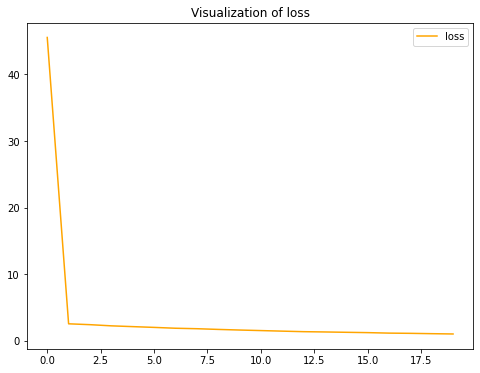

In [358]:
epochs_range = np.arange(epochs)
plt.figure(figsize=(8,6))
plt.yscale('linear')
plt.plot(epochs_range, epoch_loss_list, color='orange')
plt.title('Visualization of loss')
plt.legend(['loss'], loc = 'best')


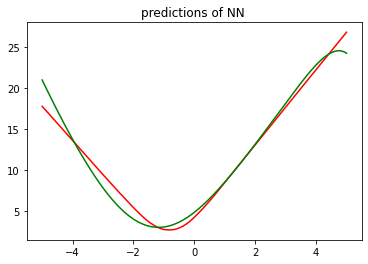

In [356]:
pred_y_list = []
x_tensor = torch.tensor(x_dataset).unsqueeze(1).to(device, dtype=torch.float)
pred_y = model(x_tensor) 
for y in pred_y:
    pred_y_list.append(y.item())
plt.plot(x_dataset, pred_y_list, color='r')
plt.plot(x_dataset, y_dataset, color='g')
plt.title('predictions of NN ')
plt.show()

이렇게 딥러닝을 사용하면 어떤 비선형함수든 잘 근사시킬 수 있습니다. 정말 놀랍지 않나요? 이는 딥러닝의 Universal Approximation Theorem 덕분입니다. 심층강화학습에서는 Q Value나 Policy를 딥러닝을 통해서 근사하게 되며, Policy Gradient나 DQN에서 딥러닝을 활용합니다. 본질적으로는 Q Value에 대한, Policy의 파라미터에 대한 회귀문제를 푸는 것이 심층강화학습의 핵심내용입니다. 




# Practice 1: Change activation function and number of neurons
뉴럴 네트워크 내의 활성화함수를 ReLU 말고 다른 함수로 변경해보세요 


# Practice 2: Overfitting neral network

딥러닝에는 학습을 위한 많은 하이퍼파라미터들이 존재합니다. 
- learning_rate
- mini batch size
- number of nodes in NN
- activation function
- type of optimizer
- number of epochs  

neural network가 학습데이터를 완전히 외워서 loss가 0에 가깝도록 학습된 것을 `오버피팅`되었다라고 표현합니다. 위의 하이퍼파라미터들을 조정해서 위에서 loss가 0.1 아래로 떨어지도록 뉴럴 네트워크를 오버피팅 시켜보세요 :) 제약조건은 `epochs`의 수가 100 이하여야 합니다. 학습이 잘되면 아래와 비슷한 그림을 볼 수 있습니다. 

![](2023-05-02-18-54-35.png)



# Summary
해당 실습파일에서는 뉴럴 네트워크를 학습시켜서 비선형함수를 근사시키는 작업을 수행했습니다.   
뉴럴 네트워크의 실체는 행렬-벡터 곱을 수행하고 비선형활성화함수를 통과시키는 것을 반복하는 것이었습니다.  
그리고 Gradient descent를 통해서 손실함수를 최소화하도록 뉴럴 네트워크의 가중치 행렬들을 업데이트 하면 원하는 함수를 근사시킬 수 있었습니다. 이것이 딥러닝의 전부입니다! 이제는 아래 문장을 이해하실 수 있을 것입니다. 
### 딥러닝 = 뉴럴 네트워크로 표현된 비선형함수를 최적화하는 것 ###

다음 실습파일에서는 MNIST 데이터셋을 분류해볼 것입니다.  

딥러닝에 대해 더 공부하고 싶으시다면 아래의 링크들을 참고하세요. 

[1] http://ko.d2l.ai/index.html  
[2] https://atcold.github.io/pytorch-Deep-Learning/ko/  
[3] https://wikidocs.net/book/2788